In [4]:
import pandas as pd
import os
import sklearn
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for split data
from sklearn.model_selection import train_test_split
# for decision tree
import xgboost
from xgboost import XGBClassifier
# for evaluation
from sklearn.metrics import confusion_matrix
# for tensorflow
import tensorflow as tf

In [5]:
df = pd.read_csv('Telecom_customer churn.csv')

In [6]:
df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [7]:
df.shape

(100000, 100)

In [8]:
df.isna().sum()

rev_Mean        357
mou_Mean        357
totmrc_Mean     357
da_Mean         357
ovrmou_Mean     357
               ... 
kid11_15       1732
kid16_17       1732
creditcd       1732
eqpdays           1
Customer_ID       0
Length: 100, dtype: int64

Text(0.5, 1.0, 'Distribution of number of missing feature of each customer')

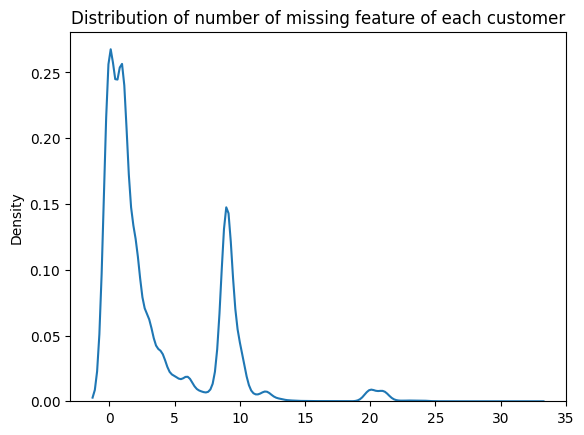

In [9]:
sns.kdeplot(df.isna().sum(axis=1))
plt.gca().set_title('Distribution of number of missing feature of each customer')

Base on the distribution above, the number of missing feature of each customer is quite small.
There are 100 columns, but the majority of these customers is only missing <= 10 columns.
However, to make the model more robust, we will exclude all customers that have more than 5 missing columns.
We will fill other columns with the average or mode value of those columns.

In [10]:
df_nnull = df[df.isna().sum(axis=1) < 5]
print(
    f"""
    If excluding customers with more than 5 missing columns, the remaining number of observation is 
    {(df_nnull.shape[0] / df.shape[0])*100} %
    of the original data
    """
)


    If excluding customers with more than 5 missing columns, the remaining number of observation is 
    72.396 %
    of the original data
    


In [11]:
# Determine the data type of each column (numeric or categorical)
numeric_cols = df_nnull.select_dtypes(include='number').columns
categorical_cols = df_nnull.select_dtypes(exclude='number').columns

Handling missing values

In [12]:
df_nnull[categorical_cols] = df_nnull[categorical_cols].fillna(df_nnull[categorical_cols].mode().iloc[0])
df_nnull[numeric_cols] = df_nnull[numeric_cols].fillna(df[numeric_cols].mean())

C:\Users\aksha\AppData\Local\Temp\ipykernel_15992\1965959571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nnull[categorical_cols] = df_nnull[categorical_cols].fillna(df_nnull[categorical_cols].mode().iloc[0])
C:\Users\aksha\AppData\Local\Temp\ipykernel_15992\1965959571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nnull[numeric_cols] = df_nnull[numeric_cols].fillna(df[numeric_cols].mean())


([<matplotlib.patches.Wedge at 0x14a8ede6390>,
 [Text(-0.015135673311449674, 1.099895863885945, '0'),
  Text(0.015135673311449539, -1.099895863885945, '1')],
 [Text(-0.008255821806245275, 0.5999431984832426, '50.4%'),
  Text(0.008255821806245203, -0.5999431984832426, '49.6%')])

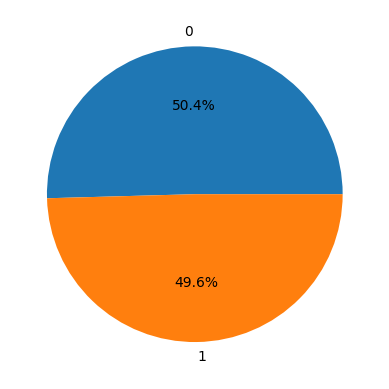

In [13]:
data = df.churn.value_counts()

plt.pie(
    data = data,
    x = data.values,
    labels = data.index,
    autopct='%1.1f%%'
)

In [14]:
index_list = []
val_list = []
for col in categorical_cols:
    index_list.append(col)
    val_list.append(len(df_nnull[categorical_cols][col].unique()))
unique_count_ser = pd.Series(val_list,index= index_list).sort_values()
print("Number of distinct options in each categorical column: ")
print(unique_count_ser)

Number of distinct options in each categorical column: 
infobase             1
creditcd             2
kid11_15             2
asl_flag             2
kid6_10              2
kid3_5               2
kid0_2               2
refurb_new           2
ownrent              2
dwlltype             2
kid16_17             2
new_cell             3
hnd_webcap           3
dualband             4
prizm_social_one     5
marital              5
HHstatin             6
dwllsize            15
ethnic              17
area                19
crclscod            51
dtype: int64


In [15]:
df_nnull = df_nnull.drop('Customer_ID',axis=1)


In [16]:
df_dum = pd.get_dummies(df_nnull)

In [17]:
df_dum.shape

(72396, 227)

In [18]:
x = df_dum.drop('churn',axis=1)
y = df_dum[['churn']]
# Split data
x_train, x_valid, y_train, y_valid = train_test_split(x, y,test_size = 0.2)

In [19]:
model_xgb = XGBClassifier()

In [20]:
model_xgb.fit(x_train, y_train, verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
x.shape

(72396, 226)

In [22]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(226, input_shape=(226,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=100)

c:\Program Files\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 969us/step - accuracy: 0.5194 - loss: 13.7175
Epoch 2/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.5223 - loss: 4.0009
Epoch 3/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 883us/step - accuracy: 0.5106 - loss: 0.6930
Epoch 4/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - accuracy: 0.5119 - loss: 0.6951
Epoch 5/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.5107 - loss: 0.6930
Epoch 6/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5099 - loss: 0.6929
Epoch 7/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5083 - loss: 0.6930
Epoch 8/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5063 - loss: 0.6931
Epoch 9/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5139 - loss: 0.6928
Epoch 10/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.5119 - loss: 0.6929
Epoch 11/100
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5130 - loss: 0.6928
Epoch 

In [23]:
model.evaluate(x_valid, y_valid)

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.5133 - loss: 0.6928


[0.6927098631858826, 0.5154696106910706]

In [24]:
yp = model.predict(x_valid)
yp[:5]

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0.4890838],
       [0.4890838],
       [0.4890838],
       [0.4890838],
       [0.4890838]], dtype=float32)

In [25]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [26]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      7464
           1       0.00      0.00      0.00      7016

    accuracy                           0.52     14480
   macro avg       0.26      0.50      0.34     14480
weighted avg       0.27      0.52      0.35     14480



C:\Users\aksha\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aksha\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aksha\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [27]:
def calculate_perform_metrics(total_confusion_matrix):
    # get components
    TP = total_confusion_matrix[1,1]
    TN = total_confusion_matrix[0,0]
    FP = total_confusion_matrix[0,1]
    FN = total_confusion_matrix[1,0]
    # calculate metrics
    metric_dict ={
        'accuracy': (TP+TN)/(TP+TN+FP+FN),
        'precision': TP/(TP+FP),
        'recall': TP/(TP+FN),
        'F1': 2 * (TP/(TP+FP) * TP/(TP+FN)) / (TP/(TP+FP) + TP/(TP+FN)) #  2 * (precision * recall) / (precision + recall)
    }
    
    return metric_dict

In [28]:
def labeling_evaluating(y_true, y_pred, threshold):
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0
    cm = confusion_matrix(y_true, y_pred)    
    # calcualte metric dict 
    metric_dict = calculate_perform_metrics(cm)
    return metric_dict, cm

{'accuracy': 0.6275552486187845, 'precision': 0.6168130128112854, 'recall': 0.6107468643101482, 'F1': 0.6137649502255963}


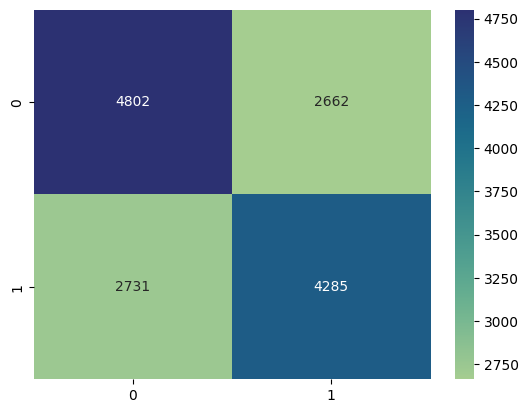

In [29]:
y_pred = model_xgb.predict(x_valid)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

In [30]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 150),
    tf.keras.layers.Dense(units = 100),
    tf.keras.layers.Dense(units = 50),
    tf.keras.layers.Dense(units = 20),
    tf.keras.layers.Dense(units = 1, activation='sigmoid'),
])

In [31]:
model_tf.compile(
    loss= 'BinaryCrossentropy',
    optimizer= 'Adam',
    metrics = ['accuracy']
)

In [32]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_valid = x_valid.astype('float32')
y_valid = y_valid.astype('float32')

In [33]:
model_tf.fit(
    x_train,
    y_train,
    validation_data = (x_valid, y_valid),
    epochs = 20
)

Epoch 1/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5198 - loss: 60.5471 - val_accuracy: 0.5367 - val_loss: 1.5198
Epoch 2/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5278 - loss: 1.3625 - val_accuracy: 0.5416 - val_loss: 0.7626
Epoch 3/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5231 - loss: 1.2332 - val_accuracy: 0.5064 - val_loss: 0.8087
Epoch 4/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5368 - loss: 0.8716 - val_accuracy: 0.5697 - val_loss: 0.7214
Epoch 5/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5324 - loss: 0.9576 - val_accuracy: 0.5705 - val_loss: 0.7099
Epoch 6/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5290 - loss: 0.9636 - val_accuracy: 0.4805 - val_loss: 0.8501
Epoch 7/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5388 - loss: 0.9106 - val_accuracy: 0.5662 - val_loss: 0.7128
Epoch 8/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5460 - loss: 0.7637 -

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
{'accuracy': 0.5841850828729281, 'precision': 0.5876651982378854, 'recall': 0.4753420752565564, 'F1': 0.5255693010795052}


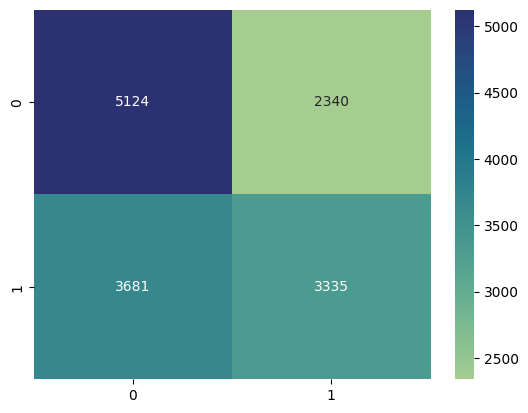

In [34]:
y_pred = model_tf.predict(x_valid)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

In [35]:
feature_importance = model_xgb.feature_importances_
feature_names = x_train.columns

In [36]:
print(feature_importance.shape, feature_names.shape)

(226,) (226,)


In [37]:
fi_ser = pd.Series(feature_importance, index = feature_names).sort_values()

Text(0.5, 1.0, "Distribution of features' importance")

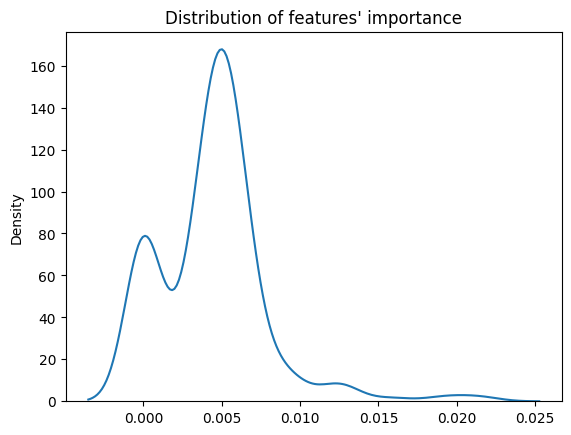

In [38]:
sns.kdeplot(fi_ser)
plt.gca().set_title("Distribution of features' importance")

In [39]:
interested_features = fi_ser[fi_ser >= 0.005].index #interested ones are those having importance score of more than 0.005

In [40]:
interested_features

Index(['new_cell_N', 'owylis_vce_Mean', 'forgntvl', 'marital_B',
       'custcare_Mean', 'avg3qty', 'inonemin_Mean', 'area_CHICAGO AREA',
       'hnd_webcap_WCMB', 'area_DC/MARYLAND/VIRGINIA AREA', 'peak_vce_Mean',
       'marital_A', 'crclscod_CY', 'avg6rev', 'ccrndmou_Mean', 'mou_rvce_Mean',
       'opk_vce_Mean', 'kid3_5_U', 'iwylis_vce_Mean', 'crclscod_CA',
       'drop_blk_Mean', 'threeway_Mean', 'avg6mou', 'HHstatin_A',
       'mou_pead_Mean', 'prizm_social_one_T', 'area_CENTRAL/SOUTH TEXAS AREA',
       'totrev', 'recv_vce_Mean', 'mou_peav_Mean', 'dwllsize_J', 'ethnic_J',
       'peak_dat_Mean', 'ethnic_N', 'change_rev', 'area_GREAT LAKES AREA',
       'avgrev', 'ethnic_D', 'actvsubs', 'area_SOUTHWEST AREA', 'crclscod_AA',
       'avg3rev', 'crclscod_DA', 'complete_Mean', 'area_NORTH FLORIDA AREA',
       'dualband_T', 'ovrrev_Mean', 'roam_Mean', 'dwllsize_O', 'cc_mou_Mean',
       'mou_opkv_Mean', 'rev_Mean', 'opk_dat_Mean', 'dwllsize_F', 'avg6qty',
       'attempt_Mean', 'ovrm

In [41]:
x_train_interested = x_train[interested_features]
x_valid_interested = x_valid[interested_features]

In [42]:
print(
    x_train_interested.shape,
    x_valid_interested.shape
)

(57916, 95) (14480, 95)


In [43]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 150),
    tf.keras.layers.Dense(units = 100),
    tf.keras.layers.Dense(units = 50),
    tf.keras.layers.Dense(units = 20),
    tf.keras.layers.Dense(units = 1, activation='sigmoid'),
])

model_tf.compile(
    loss= 'BinaryCrossentropy',
    optimizer= 'Adam',
    metrics = ['accuracy']
)

In [44]:
model_tf.fit(
    x_train_interested,
    y_train,
    validation_data = (x_valid_interested, y_valid),
    epochs = 10
)

Epoch 1/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5186 - loss: 56.7498 - val_accuracy: 0.5546 - val_loss: 1.1117
Epoch 2/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5261 - loss: 1.3166 - val_accuracy: 0.4956 - val_loss: 0.9422
Epoch 3/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5235 - loss: 1.2506 - val_accuracy: 0.5492 - val_loss: 0.7749
Epoch 4/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5394 - loss: 1.2089 - val_accuracy: 0.5268 - val_loss: 0.7771
Epoch 5/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5436 - loss: 0.8686 - val_accuracy: 0.5325 - val_loss: 0.8384
Epoch 6/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5451 - loss: 0.8277 - val_accuracy: 0.5363 - val_loss: 0.7527
Epoch 7/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5393 - loss: 0.7899 - val_accuracy: 0.5594 - val_loss: 0.7080
Epoch 8/10
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5474 - loss: 0.8016 -

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
{'accuracy': 0.5662983425414365, 'precision': 0.5441458733205374, 'recall': 0.6465222348916762, 'F1': 0.5909327774882751}


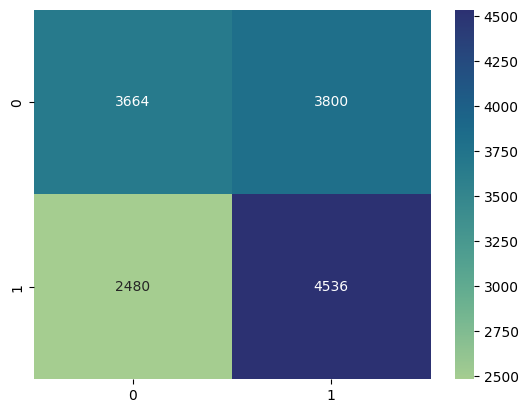

In [45]:
y_pred = model_tf.predict(x_valid_interested)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

In [46]:
model_xgb = XGBClassifier()

In [47]:
model_xgb.fit(x_train_interested, y_train, verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

{'accuracy': 0.6287983425414365, 'precision': 0.6184837545126354, 'recall': 0.6104618015963512, 'F1': 0.6144465963704182}


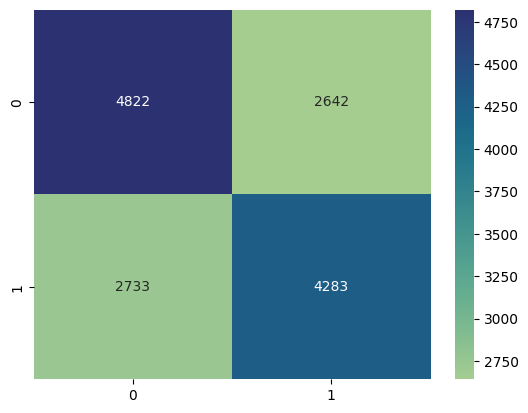

In [48]:
y_pred = model_xgb.predict(x_valid_interested)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 1, 2, 3, 4, 5]
}

# Initialize the model
model = XGBRegressor()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train_interested, y_train)

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
